In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, ZGate
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [2]:
num_input = 3
num_qubits = num_input * 2

In [3]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [4]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [5]:
def get_ctrl_state(controls, anti_controls):
    # num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
    return ctrl_state

In [6]:
def szegedy_step(qc):
    multi_cx(qc, [2], [num_input + 1, num_input + 2], num_input + 0)
    multi_cx(qc, [2], [num_input + 2], num_input + 1)
    qc.cx(2, num_input + 2)

    multi_cx(qc, [1], [num_input + 1], num_input + 0)
    qc.cx(1, num_input + 1)

    qc.cx(0, num_input + 0)

    multi_cx(qc, [], [num_input + 0], num_input + 1)
    qc.h(num_input + 0)
    multi_cz(qc, [num_input + 0], [num_input + 1], num_input + 2)
    qc.h(num_input + 0)
    multi_cx(qc, [], [num_input + 0], num_input + 1)

    multi_cx(qc, [2, num_input + 1, num_input + 2], [], num_input + 0)
    multi_cx(qc, [2, num_input + 2], [], num_input + 1)
    qc.cx(2, num_input + 2)

    multi_cx(qc, [1, num_input + 1], [], num_input + 0)
    multi_cx(qc, [1], [], num_input + 1)
    qc.cx(0, num_input + 0)

    qc.swap(2, num_input + 2)
    qc.swap(1, num_input + 1)
    qc.swap(0, num_input + 0)
    
    # qc.draw(output="latex_source", filename="qcircuit.tex")
    qc.draw(output="mpl")

dict_keys(['100', '111']) dict_values([np.float64(0.4999999999999999), np.float64(0.4999999999999999)])
dict_keys(['000']) dict_values([np.float64(0.9999999999999982)])
dict_keys(['100', '101', '110', '111']) dict_values([np.float64(0.4999999999999982), np.float64(3.8518598887744666e-34), np.float64(1.5407439555097866e-33), np.float64(0.49999999999999845)])
dict_keys(['000', '001', '010', '011']) dict_values([np.float64(0.4999999999999974), np.float64(0.24999999999999867), np.float64(7.992609269207012e-33), np.float64(0.2499999999999987)])
dict_keys(['100', '101', '110', '111']) dict_values([np.float64(0.37499999999999756), np.float64(0.24999999999999833), np.float64(0.12499999999999908), np.float64(0.24999999999999845)])
dict_keys(['000', '001', '010', '011']) dict_values([np.float64(0.6249999999999951), np.float64(0.06249999999999948), np.float64(0.124999999999999), np.float64(0.1874999999999984)])
dict_keys(['100', '101', '110', '111']) dict_values([np.float64(0.2187499999999979), n

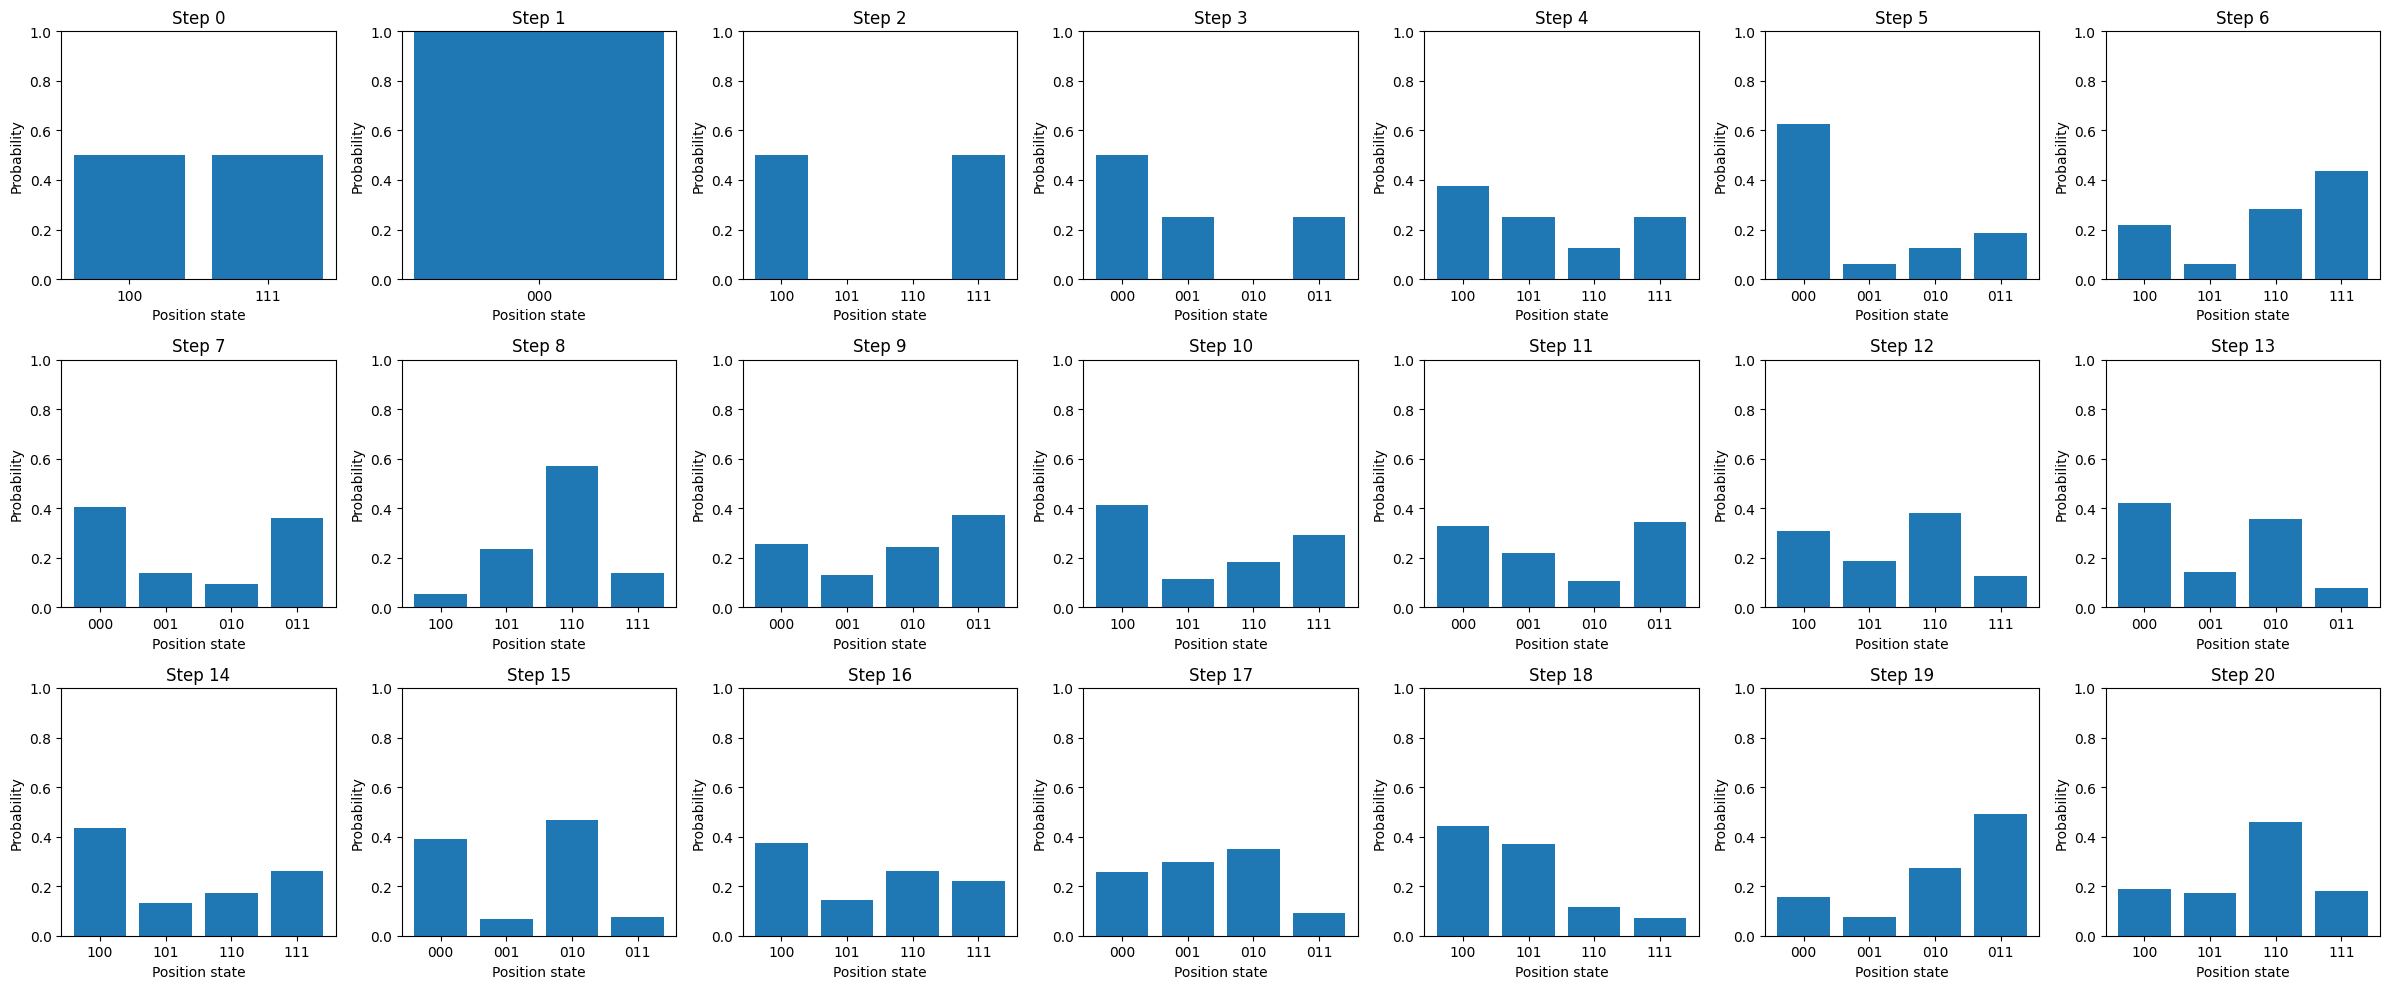

In [25]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

steps = 20

# Apply Hadamard coin operator
qc.h(num_input + 0)
qc.x(num_input + 2)
qc.cx(num_input + 0, num_input + 1)
# done with initail setup
# qc.barrier()

states = [Statevector.from_instruction(qc)]
szegedy_step(qc)
states.append(Statevector.from_instruction(qc))
for _ in range(steps-1):
    qc.h(num_input + 0)
    qc.cx(num_input + 0, num_input + 1)
    szegedy_step(qc)
    states.append(Statevector.from_instruction(qc))


fig, axs = plt.subplots(3, 7, figsize=(24, 10))
axs = axs.flatten()
for i, state in enumerate(states):
    probs = state.probabilities_dict()
    filtered = {}
    for key, val in probs.items():
        pos = key[:num_input]
        filtered[pos] = filtered.get(pos, 0) + val
    print(filtered.keys(), filtered.values())
    axs[i].bar(filtered.keys(), filtered.values())
    axs[i].set_title(f"Step {i}")
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel("Position state")
    axs[i].set_ylabel("Probability")

plt.tight_layout()
plt.show()

# qc.draw(output="mpl")



In [8]:

# Simulate the circuit
# simulator = Aer.get_backend("qasm_simulator")

qc = transpile(qc, simulator)
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts(qc)

print("Measurement outcomes:", counts)
plot_histogram(counts, title='res')

QiskitError: 'No counts for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14eec7b10>"'